In [ ]:
import gymnasium
from gymnasium import spaces
import numpy as np

In [ ]:
class CompetitiveAGIEnv(gymnasium.Env):
    """Competitive AGI Race Environment with Two Parties and State Validation"""

    def __init__(self):
        super(CompetitiveAGIEnv, self).__init__()

        # Defining collaboration modes
        self.COLLAB_MODES = {
            'INDEPENDENT': 0,   # Both parties working independently (never collaborated)
            'COLLABORATIVE': 1, # Both parties actively collaborating
            'POST_COLLAB': 2,   # Both previously collaborated but now independent
        }

        # Defining party statuses
        self.PARTY_STATUS = {
            'EXPLORING': 0,     # Actively exploring
            'RETREATED': 1,     # Retreated
            'FOUND_AGI': 2,     # Found AGI
        }

        # Collaboration mode (applies to both parties)
        self.collab_mode = self.COLLAB_MODES['INDEPENDENT']

        # Individual party statuses
        self.party_1_status = self.PARTY_STATUS['EXPLORING']
        self.party_2_status = self.PARTY_STATUS['EXPLORING']

        # Track which party has broken collaboration
        self.party_1_broke_collab = False
        self.party_2_broke_collab = False

        # Track resources
        self.party_1_resources = 100
        self.party_2_resources = 100

        # 4 actions for each party:
        # 0 = Explore independently
        # 1 = Retreat (take a break)
        # 2 = Initiate/continue collaboration
        # 3 = Break collaboration (if currently collaborating)
        # Each party chooses one action, so the combined action space is (4, 4)
        self.n_actions = 4
        self.action_space = spaces.Tuple((spaces.Discrete(self.n_actions), spaces.Discrete(self.n_actions)))

        # The observation space includes:
        # - Collaboration mode (0, 1, 2)
        # - Party 1 status (0, 1, 2)
        # - Party 2 status (0, 1, 2)
        # - Party 1 resources (float)
        # - Party 2 resources (float)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(3),  # collaboration mode
            spaces.Discrete(3),  # party_1_status
            spaces.Discrete(3),  # party_2_status
            spaces.Box(low=0, high=float('inf'), shape=(1,), dtype=np.float32),  # party_1_resources
            spaces.Box(low=0, high=float('inf'), shape=(1,), dtype=np.float32),  # party_2_resources
        ))

        # Base probabilities for AGI discovery
        self.independent_agi_prob = 0.01
        self.collaborative_agi_prob = 0.03
        self.post_collab_agi_prob = 0.015

        # Resource dynamics
        self.explore_independent_cost = 1
        self.explore_collaborative_cost = 3
        self.retreat_reward = 10
        self.collaboration_initiation_cost = 5
        self.agi_reward = 100

        # Competition penalty: if the opponent finds AGI first
        self.competition_penalty = -50

        # Max environment steps
        self.max_steps = 1000
        self.current_step = 0

        # Defining the transition probabilities and rewards for each party
        # Structure: {(collab_mode, party_status): {action: [{next_status, prob, reward, effects}, ...]}}
        self.party_1_transitions = {
            (self.PARTY_STATUS['EXPLORING'], self.COLLAB_MODES['INDEPENDENT']): {
                0: [  # Explore independently
                    {"next_status": self.PARTY_STATUS['FOUND_AGI'], "prob": self.independent_agi_prob,
                        "reward": self.agi_reward, "resource_change": -self.explore_independent_cost,
                        "effects": [("party_2_reward", self.competition_penalty,
                                    lambda: self.party_2_status == self.PARTY_STATUS['EXPLORING'])]},
                    {"next_status": self.PARTY_STATUS['EXPLORING'], "prob": 1 - self.independent_agi_prob,
                        "reward": -1, "resource_change": -self.explore_independent_cost, "effects": []}                        #1. CHANGED REWARD FROM 0 TO -1
                ],
                1: [  # Retreat
                    {"next_status": self.PARTY_STATUS['RETREATED'], "prob": 1.0,
                        "reward": self.retreat_reward, "resource_change": self.retreat_reward, "effects": []}
                ],
                2: [  # Try to initiate collaboration. COLLABORATIVE CASE ALREADY HANDLED EARLIER
                    {"next_status": self.PARTY_STATUS['EXPLORING'], "prob": 1.0,
                        "reward": -5, "resource_change": 0, "effects": []}  # Actual collab handled separately                 #3. CHANGED REWARD FROM 0 TO -5
                ],
                # 3: [  # Invalid in this state                                                                             #2. REMOVED INVALID ACTIONS
                #     {"next_status": self.PARTY_STATUS['EXPLORING'], "prob": 1.0,
                #      "reward": -5, "resource_change": 0, "effects": []}  # Penalty for invalid action
                # ]
            },
            (self.PARTY_STATUS['EXPLORING'], self.COLLAB_MODES['COLLABORATIVE']): {
                # 0: [  # Explore collaboratively                                                                           #2. REMOVED INVALID ACTIONS
                #     {"next_status": self.PARTY_STATUS['FOUND_AGI'], "prob": self.collaborative_agi_prob,
                #      "reward": self.agi_reward, "resource_change": -self.explore_collaborative_cost,
                #      "effects": [("party_2_status", self.PARTY_STATUS['FOUND_AGI'],
                #                  lambda: self.party_2_status == self.PARTY_STATUS['EXPLORING']),
                #                 ("party_2_reward", self.agi_reward,
                #                  lambda: self.party_2_status == self.PARTY_STATUS['EXPLORING'])]},
                #     {"next_status": self.PARTY_STATUS['EXPLORING'], "prob": 1 - self.collaborative_agi_prob,
                #      "reward": 0, "resource_change": -self.explore_collaborative_cost, "effects": []}
                # ],
                1: [  # Retreat
                    {"next_status": self.PARTY_STATUS['RETREATED'], "prob": 1.0,
                        "reward": self.retreat_reward, "resource_change": self.retreat_reward, "effects": []}
                ],
                2: [  # Explore collaboratively
                    {"next_status": self.PARTY_STATUS['FOUND_AGI'], "prob": self.collaborative_agi_prob,
                        "reward": self.agi_reward, "resource_change": -self.explore_collaborative_cost,
                        "effects": [("party_2_status", self.PARTY_STATUS['FOUND_AGI'],
                                    lambda: self.party_2_status == self.PARTY_STATUS['EXPLORING']),
                                ("party_2_reward", self.agi_reward,
                                    lambda: self.party_2_status == self.PARTY_STATUS['EXPLORING'])]},
                    {"next_status": self.PARTY_STATUS['EXPLORING'], "prob": 1 - self.collaborative_agi_prob,
                        "reward": -5, "resource_change": -self.explore_collaborative_cost, "effects": []}                      #3. CHANGED REWARD FROM 0 TO -5
                ],
                3: [  # Break collaboration, COLLABORATIVE CASE ALREADY HANDLED EARLIER
                    {"next_status": self.PARTY_STATUS['EXPLORING'], "prob": 1.0,
                        "reward": 0, "resource_change": 0, "effects": [("party_1_broke_collab", True, lambda: True)]}
                ]
            },
            (self.PARTY_STATUS['EXPLORING'], self.COLLAB_MODES['POST_COLLAB']): {
                0: [  # Explore after collaboration
                    {"next_status": self.PARTY_STATUS['FOUND_AGI'], "prob": self.post_collab_agi_prob,
                        "reward": self.agi_reward, "resource_change": -self.explore_independent_cost,
                        "effects": [("party_2_reward", self.competition_penalty,
                                    lambda: self.party_2_status == self.PARTY_STATUS['EXPLORING'])]},
                    {"next_status": self.PARTY_STATUS['EXPLORING'], "prob": 1 - self.post_collab_agi_prob,
                        "reward": -1, "resource_change": -self.explore_independent_cost, "effects": []}                        #1. CHANGED REWARD FROM 0 TO -1
                ],
                1: [  # Retreat
                    {"next_status": self.PARTY_STATUS['RETREATED'], "prob": 1.0,
                        "reward": self.retreat_reward, "resource_change": self.retreat_reward, "effects": []}
                ],
                # 2: [  # Invalid in this state
                #     {"next_status": self.PARTY_STATUS['EXPLORING'], "prob": 1.0,
                #      "reward": 0, "resource_change": 0, "effects": []}  # Actual collab handled separately
                # ],
                # 3: [  # Invalid in this state                                                                                 #2. REMOVED INVALID ACTIONS
                #     {"next_status": self.PARTY_STATUS['EXPLORING'], "prob": 1.0,
                #      "reward": -5, "resource_change": 0, "effects": []}  # Penalty for invalid action
                # ]
            }
        }

        # Define similar transitions for party 2 (could be identical or asymmetric)
        self.party_2_transitions = self.party_1_transitions.copy()  # Deep copy if needed

        # Define joint collaboration transitions
        self.collaboration_transitions = {
            self.COLLAB_MODES['INDEPENDENT']: {
                (2, 2): {"next_mode": self.COLLAB_MODES['COLLABORATIVE'], "resource_change": -self.collaboration_initiation_cost}
            },
            self.COLLAB_MODES['COLLABORATIVE']: {
                (2, 2): {"next_mode": self.COLLAB_MODES['COLLABORATIVE'], "resource_change": -5},
                (3, 2): {"next_mode": self.COLLAB_MODES['POST_COLLAB'], "resource_change": -1},
                (2, 3): {"next_mode": self.COLLAB_MODES['POST_COLLAB'], "resource_change": -1},
                (3, 3): {"next_mode": self.COLLAB_MODES['POST_COLLAB'], "resource_change": -1},
                # # Any other action combination breaks collaboration
                # "default": {"next_mode": self.COLLAB_MODES['POST_COLLAB'], "resource_change": 0}
            },
            # self.COLLAB_MODES['POST_COLLAB']: {
            #     (2, 2): {"next_mode": self.COLLAB_MODES['COLLABORATIVE'], "resource_change": -self.collaboration_initiation_cost}
            # }
        }

    def _get_observation(self):
        """Return the current observation (state)."""
        return (
            self.collab_mode,
            self.party_1_status,
            self.party_2_status,
            np.array([self.party_1_resources], dtype=np.float32),
            np.array([self.party_2_resources], dtype=np.float32),
        )

    def _is_terminal(self):
        """Check if the episode has reached a terminal state."""
        return (self.party_1_status != self.PARTY_STATUS['EXPLORING'] or
                self.party_2_status != self.PARTY_STATUS['EXPLORING'] or
                self.current_step >= self.max_steps or
                self.party_1_resources <= 0 or
                self.party_2_resources <= 0)

    def _get_terminal_info(self):
        """Gather information about how the episode ended."""
        info = {}

        if self.party_1_resources <= 0:
            info["bankrupt"] = "party_1"
        if self.party_2_resources <= 0:
            info["bankrupt"] = "party_2" if "bankrupt" not in info else "both"

        if self.current_step >= self.max_steps:
            info["timeout"] = True

        if self.party_1_status == self.PARTY_STATUS['FOUND_AGI'] and self.party_2_status == self.PARTY_STATUS['FOUND_AGI']:
            info["winner"] = "both"
        elif self.party_1_status == self.PARTY_STATUS['FOUND_AGI']:
            info["winner"] = "party_1"
        elif self.party_2_status == self.PARTY_STATUS['FOUND_AGI']:
            info["winner"] = "party_2"

        if "winner" not in info and "bankrupt" not in info and not info.get("timeout", False):
            # Someone retreated
            if self.party_1_status == self.PARTY_STATUS['RETREATED'] and self.party_2_status == self.PARTY_STATUS['RETREATED']:
                info["both_retreated"] = True
            elif self.party_1_status == self.PARTY_STATUS['RETREATED']:
                info["retreated"] = "party_1"
            elif self.party_2_status == self.PARTY_STATUS['RETREATED']:
                info["retreated"] = "party_2"

        return info

    # def _process_collaboration_actions(self, action_1, action_2):
    #     """Process collaboration dynamics based on both parties' actions.
    #         HERE, True and False JUST INDICATE WHETHER WE MADE SOME CHANGE BASED ON THEIR STATE, AND COLLABORATION-RELATED ACTION OR NOT.
    #         WE COULD HAVE AVOIDED TRUE, AND FALSE ALTOGETHER"""

    #     # Starting collaboration requires both parties to choose action 2
    #     if (self.collab_mode != self.COLLAB_MODES['COLLABORATIVE'] and
    #         action_1 == 2 and action_2 == 2):

    #         # Both parties agree to collaborate
    #         self.collab_mode = self.COLLAB_MODES['COLLABORATIVE']
    #         self.party_1_resources -= self.collaboration_initiation_cost
    #         self.party_2_resources -= self.collaboration_initiation_cost
    #         return True

    #     # Breaking collaboration happens if either party chooses action 3
    #     elif (self.collab_mode == self.COLLAB_MODES['COLLABORATIVE'] and
    #           (action_1 == 3 or action_2 == 3)):

    #         # Collaboration is broken
    #         self.collab_mode = self.COLLAB_MODES['POST_COLLAB']

    #         # Record who broke collaboration
    #         if action_1 == 3:
    #             self.party_1_broke_collab = True
    #         if action_2 == 3:
    #             self.party_2_broke_collab = True
    #         return True

    #     # Continuing collaboration requires both to choose action 2
    #     elif (self.collab_mode == self.COLLAB_MODES['COLLABORATIVE'] and
    #           not (action_1 == 2 and action_2 == 2)):

    #         # Collaboration ends (not actively broken, but not continued)
    #         self.collab_mode = self.COLLAB_MODES['POST_COLLAB']
    #         return True
    #     return False

    def _process_collaboration_actions(self, action_1, action_2):
        collab_action_key = (action_1, action_2)

        # Apply collaboration transition if defined for this action pair
        if self.collab_mode in self.collaboration_transitions:
            collab_state_transitions = self.collaboration_transitions[self.collab_mode]

            if collab_action_key in collab_state_transitions:
                transition = collab_state_transitions[collab_action_key]

                # Apply collaboration transition
                old_collab_mode = self.collab_mode
                self.collab_mode = transition["next_mode"]

                # Apply resource changes for collaboration transitions
                if transition["resource_change"] != 0:
                    self.party_1_resources += transition["resource_change"]
                    self.party_2_resources += transition["resource_change"]

                # Record collaboration break
                if old_collab_mode == self.COLLAB_MODES['COLLABORATIVE'] and self.collab_mode == self.COLLAB_MODES['POST_COLLAB']:
                    if action_1 == 3:
                        self.party_1_broke_collab = True
                    if action_2 == 3:
                        self.party_2_broke_collab = True

    def _get_agi_probability(self, party_id):
        """Get the probability of finding AGI based on collaboration mode."""
        if self.collab_mode == self.COLLAB_MODES['INDEPENDENT']:
            return self.independent_agi_prob
        elif self.collab_mode == self.COLLAB_MODES['COLLABORATIVE']:
            return self.collaborative_agi_prob
        else:  # POST_COLLAB
            return self.post_collab_agi_prob

    def _process_party1_actions(self, action_1, reward_1, reward_2):
        # Process party 1's action if not in terminal state
        if self.party_1_status == self.PARTY_STATUS['EXPLORING']:
            state_key = (self.party_1_status, self.collab_mode)

            if state_key in self.party_1_transitions and action_1 in self.party_1_transitions[state_key]:
                transitions = self.party_1_transitions[state_key][action_1]

                # Select transition based on probabilities
                probs = [t["prob"] for t in transitions]
                transition_idx = np.random.choice(len(transitions), p=probs)
                transition = transitions[transition_idx]

                # Apply transition
                self.party_1_status = transition["next_status"]
                reward_1 += transition["reward"]
                self.party_1_resources += transition["resource_change"]

                # Apply side effects
                for effect in transition["effects"]:
                    target, value, condition = effect
                    if condition():
                        if target == "party_2_reward":
                            reward_2 += value
                        elif target == "party_2_status":
                            self.party_2_status = value
                        elif target == "party_1_broke_collab":
                            self.party_1_broke_collab = value

    def _process_party2_actions(self, action_2, reward_1, reward_2):
        # Process party 2's action if not in terminal state and if party 1's action didn't
        # already cause party 2 to find AGI through collaboration
        if self.party_2_status == self.PARTY_STATUS['EXPLORING']:
            state_key = (self.party_2_status, self.collab_mode)

            if state_key in self.party_2_transitions and action_2 in self.party_2_transitions[state_key]:
                transitions = self.party_2_transitions[state_key][action_2]

                # Select transition based on probabilities
                probs = [t["prob"] for t in transitions]
                transition_idx = np.random.choice(len(transitions), p=probs)
                transition = transitions[transition_idx]

                # Apply transition
                self.party_2_status = transition["next_status"]
                reward_2 += transition["reward"]
                self.party_2_resources += transition["resource_change"]

                # Apply side effects
                for effect in transition["effects"]:
                    target, value, condition = effect
                    if condition():
                        if target == "party_1_reward":
                            reward_1 += value
                        elif target == "party_1_status":
                            self.party_1_status = value
                        elif target == "party_2_broke_collab":
                            self.party_2_broke_collab = value


    def step(self, action):
        """Take a step in the environment with actions from both parties."""
        """Take a step using transition matrices instead of if-else logic."""
        action_1, action_2 = action

        # Validate actions
        assert 0 <= action_1 < 4, f"Invalid action for party 1: {action_1}"
        assert 0 <= action_2 < 4, f"Invalid action for party 2: {action_2}"

        # If already in terminal state, return without changes
        if self._is_terminal():
            return self._get_observation(), (0, 0), True, False, self._get_terminal_info()

        # Process collaboration transitions first
        self._process_collaboration_actions(action_1, action_2)

        reward_1, reward_2 = 0, 0
        info = {}

        self._process_party1_actions(action_1, reward_1, reward_2)
        self._process_party2_actions(action_2, reward_1, reward_2)

        # Increment step counter
        self.current_step += 1

        # Determine if episode has ended
        done = self._is_terminal()

        # Gather additional info for terminal states
        if done:
            info.update(self._get_terminal_info())

        return self._get_observation(), (reward_1, reward_2), done, False, info



    def reset(self, seed=None, options=None):
        """Reset the environment to initial state."""
        if seed is not None:
            np.random.seed(seed)

        self.collab_mode = self.COLLAB_MODES['INDEPENDENT']
        self.party_1_status = self.PARTY_STATUS['EXPLORING']
        self.party_2_status = self.PARTY_STATUS['EXPLORING']
        self.party_1_broke_collab = False
        self.party_2_broke_collab = False
        self.party_1_resources = 100
        self.party_2_resources = 100
        self.current_step = 0

        return self._get_observation(), {}

    def close(self):
        """Clean up resources."""
        pass

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class AGIRaceObsPreprocessor(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, obs_tuple):
        """
        obs_tuple: tuple of the form
        (collab_mode, party_1_status, party_2_status, party_1_resources, party_2_resources)
        Each element can be a scalar or a small tensor (e.g. list or np.array).
        """
        collab_mode, p1_status, p2_status, p1_resources, p2_resources = obs_tuple

        # Convert to tensors if not already
        collab_mode = torch.as_tensor(collab_mode, dtype=torch.long)
        p1_status = torch.as_tensor(p1_status, dtype=torch.long)
        p2_status = torch.as_tensor(p2_status, dtype=torch.long)
        p1_res = torch.as_tensor(p1_resources, dtype=torch.float32).flatten()
        p2_res = torch.as_tensor(p2_resources, dtype=torch.float32).flatten()

        # Add batch dimension if needed
        if collab_mode.dim() == 0:
            collab_mode = collab_mode.unsqueeze(0)
        if p1_status.dim() == 0:
            p1_status = p1_status.unsqueeze(0)
        if p2_status.dim() == 0:
            p2_status = p2_status.unsqueeze(0)
        if p1_res.dim() == 1:
            p1_res = p1_res.unsqueeze(0)
        if p2_res.dim() == 1:
            p2_res = p2_res.unsqueeze(0)

        # One-hot encode categorical variables
        collab_one_hot = F.one_hot(collab_mode, num_classes=3).float()
        p1_status_one_hot = F.one_hot(p1_status, num_classes=3).float()
        p2_status_one_hot = F.one_hot(p2_status, num_classes=3).float()

        # Concatenate everything
        return torch.cat([
            collab_one_hot,
            p1_status_one_hot,
            p2_status_one_hot,
            p1_res,
            p2_res
        ], dim=1)


# Testing code below

In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time

# First, make sure your CompetitiveAGIEnv class is defined correctly
# Then, run these tests:

def test_basic_environment():
    """Test basic environment functionality."""
    env = CompetitiveAGIEnv()
    obs, _ = env.reset()

    print("Initial Observation:", obs)
    print("Action Space:", env.action_space)
    print("Observation Space:", env.observation_space)

    # Test a single step with random actions
    action = (random.randint(0, 3), random.randint(0, 3))
    next_obs, rewards, done, _, info = env.step(action)

    print(f"\nTook action: {action}")
    print("Next Observation:", next_obs)
    print("Rewards:", rewards)
    print("Done:", done)
    print("Info:", info)

    # Reset and run a full episode with random actions
    obs, _ = env.reset()
    done = False
    total_steps = 0

    while not done and total_steps < 100:
        action = (random.randint(0, 3), random.randint(0, 3))
        obs, rewards, done, _, info = env.step(action)
        total_steps += 1

    print(f"\nEpisode ended after {total_steps} steps")
    print("Final Observation:", obs)
    print("Final Info:", info)


def test_collaboration_dynamics():
    """Test collaboration-specific dynamics."""
    env = CompetitiveAGIEnv()
    obs, _ = env.reset()

    # Test initiating collaboration
    print("Testing collaboration initiation...")
    action = (2, 2)  # Both parties choose to collaborate
    next_obs, rewards, done, _, info = env.step(action)

    print(f"Collaboration Mode: {next_obs[0]}")
    print(f"Resources P1: {next_obs[3][0]}, P2: {next_obs[4][0]}")

    if next_obs[0] == env.COLLAB_MODES['COLLABORATIVE']:
        print("✓ Collaboration successfully initiated")
    else:
        print("✗ Collaboration failed to initiate")

    # Test collaborative exploration
    if not done:
        action = (0, 0)  # Both parties explore while in collaboration
        next_obs, rewards, done, _, info = env.step(action)
        print("\nBoth parties explored while collaborating:")
        print(f"Resources P1: {next_obs[3][0]}, P2: {next_obs[4][0]}")

    # Test breaking collaboration
    env.reset()
    # First initiate collaboration
    env.step((2, 2))

    # Then break it
    print("\nTesting collaboration breaking...")
    action = (3, 0)  # Party 1 breaks collaboration
    next_obs, rewards, done, _, info = env.step(action)

    print(f"Collaboration Mode: {next_obs[0]}")
    if next_obs[0] == env.COLLAB_MODES['POST_COLLAB']:
        print("✓ Collaboration successfully broken")
    else:
        print("✗ Collaboration failed to break")

    # Test if broke_collab flag is set
    print(f"Party 1 broke collab: {env.party_1_broke_collab}")
    print(f"Party 2 broke collab: {env.party_2_broke_collab}")

# Run the tests
if __name__ == "__main__":
    print("=== Basic Environment Test ===")
    test_basic_environment()

    print("\n=== Collaboration Dynamics Test ===")
    test_collaboration_dynamics()

=== Basic Environment Test ===
Initial Observation: (0, 0, 0, array([100.], dtype=float32), array([100.], dtype=float32))
Action Space: Tuple(Discrete(4), Discrete(4))
Observation Space: Tuple(Discrete(3), Discrete(3), Discrete(3), Box(0.0, inf, (1,), float32), Box(0.0, inf, (1,), float32))

Took action: (0, 0)
Next Observation: (0, 0, 0, array([99.], dtype=float32), array([99.], dtype=float32))
Rewards: (0, 0)
Done: False
Info: {}

Episode ended after 1 steps
Final Observation: (0, 1, 0, array([110.], dtype=float32), array([100.], dtype=float32))
Final Info: {'retreated': 'party_1'}

=== Collaboration Dynamics Test ===
Testing collaboration initiation...
Collaboration Mode: 1
Resources P1: 92.0, P2: 92.0
✓ Collaboration successfully initiated

Both parties explored while collaborating:
Resources P1: 92.0, P2: 92.0

Testing collaboration breaking...
Collaboration Mode: 1
✗ Collaboration failed to break
Party 1 broke collab: True
Party 2 broke collab: False


## Deep Q Learning

### Agent

In [ ]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

### Training

In [ ]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = CompetitiveAGIEnv()
preprocessor = AGIRaceObsPreprocessor()

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [ ]:
import math
import random
import torch
import torch.nn as nn
import torch.optim as optim

class DQNAgent:
    def __init__(
        self,
        n_observations,
        n_actions,
        device,
        lr=1e-4,
        gamma=0.99,
        tau=0.005,
        eps_start=0.9,
        eps_end=0.05,
        eps_decay=1000,
        batch_size=128,
        memory_size=10000,
        amsgrad=True,
    ):
        self.device = device
        self.n_actions = n_actions
        self.gamma = gamma
        self.tau = tau
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.batch_size = batch_size

        # Networks
        self.policy_net = DQN(n_observations, n_actions).to(device)
        self.target_net = DQN(n_observations, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # Optimizer
        self.optimizer = optim.AdamW(
            self.policy_net.parameters(), lr=lr, amsgrad=amsgrad
        )
        # Replay memory
        self.memory = ReplayMemory(memory_size)

        # Step counter for epsilon
        self.steps_done = 0

    def select_action(self, state):
        """
        Choose action using epsilon-greedy over policy_net.
        state: preprocessed tensor, shape [1, n_observations]
        returns: tensor([[action]], device=device)
        """
        sample = random.random()
        eps_threshold = self.eps_end + (
            self.eps_start - self.eps_end
        ) * math.exp(-1.0 * self.steps_done / self.eps_decay)
        self.steps_done += 1

        if sample > eps_threshold:
            with torch.no_grad():
                return (
                    self.policy_net(state)
                    .max(1)
                    .indices
                    .view(1, 1)
                )
        else:
            return torch.tensor(
                [[random.randrange(self.n_actions)]],
                device=self.device,
                dtype=torch.long,
            )

    def optimize_model(self):
        """
        Sample from replay memory and perform a single gradient step.
        """
        if len(self.memory) < self.batch_size:
            return None

        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        # Compute mask and concatenate states
        non_final_mask = torch.tensor(
            tuple(s is not None for s in batch.next_state),
            device=self.device,
            dtype=torch.bool,
        )
        non_final_next_states = torch.cat(
            [s for s in batch.next_state if s is not None]
        )
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Q(s_t, a)
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # V(s_{t+1})
        next_state_values = torch.zeros(
            self.batch_size, device=self.device
        )
        with torch.no_grad():
            next_state_values[non_final_mask] = (
                self.target_net(non_final_next_states)
                .max(1)
                .values
            )

        expected_state_action_values = (
            next_state_values * self.gamma
        ) + reward_batch

        # Loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(
            state_action_values,
            expected_state_action_values.unsqueeze(1),
        )

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(
            self.policy_net.parameters(), 100
        )
        self.optimizer.step()

        return loss

    def update_target_network(self):
        """
        Soft-update of target network: \theta_target = \tau \theta_policy + (1-\tau) \theta_target
        """
        for target_param, policy_param in zip(
            self.target_net.parameters(), self.policy_net.parameters()
        ):
            target_param.data.copy_(
                self.tau * policy_param.data + (1.0 - self.tau) * target_param.data
            )

    def save(self, path):
        torch.save(
            {
                'policy_state_dict': self.policy_net.state_dict(),
                'target_state_dict': self.target_net.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'steps_done': self.steps_done
            },
            path,
        )

    def load(self, path):
        checkpoint = torch.load(path, map_location=self.device)
        self.policy_net.load_state_dict(checkpoint['policy_state_dict'])
        self.target_net.load_state_dict(checkpoint['target_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.steps_done = checkpoint.get('steps_done', 0)

    def update_target_network(self, tau=0.005):
        target_dict = self.target_net.state_dict()
        policy_dict = self.policy_net.state_dict()
        for key in policy_dict:
            target_dict[key] = policy_dict[key] * tau + target_dict[key] * (1.0 - tau)
        self.target_net.load_state_dict(target_dict)

# Usage example:
# agent = DQNAgent(n_observations, n_actions, device)
# state, _ = env.reset()
# state = preprocessor(state)
# action = agent.select_action(state)
# next_state, reward, done, _, _ = env.step(action.item())
# ... memory.push(state, action, reward, next_state) ...
# loss = agent.optimize_model()
# agent.update_target_network()


In [ ]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = 1
# Get the number of state observations
state, info = env.reset()
state = preprocessor(state)
n_observations = state.shape[1]
print(n_actions)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.

            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

1


In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

### Visualization

<ipython-input-64-7abe11b0c341>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)
<ipython-input-64-7abe11b0c341>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device)


Complete


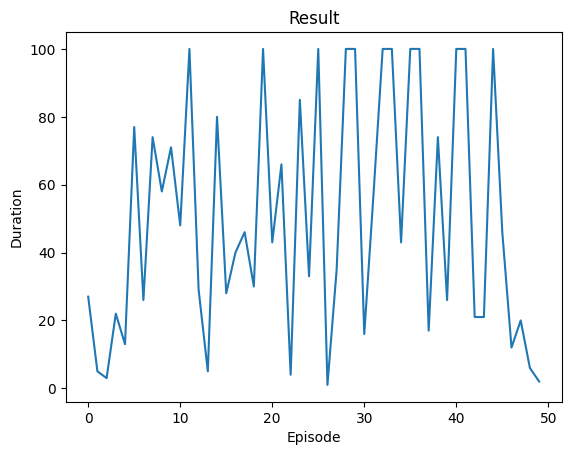

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 10_000
else:
    num_episodes = 50

agent1 = DQNAgent(n_observations, n_actions, device)
agent2 = DQNAgent(n_observations, n_actions, device)
# Usage example:
# agent = DQNAgent(n_observations, n_actions, device)
# state, _ = env.reset()
# state = preprocessor(state)
# action = agent.select_action(state)
# next_state, reward, done, _, _ = env.step(action.item())
# ... memory.push(state, action, reward, next_state) ...
# loss = agent.optimize_model()
# agent.update_target_network()


for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = preprocessor(state)
    state = torch.tensor(state, dtype=torch.float32, device=device)
    for t in count():
        action1 = agent1.select_action(state)
        action2 = agent2.select_action(state)

        # Take a step in the environment
        observation, reward, terminated, truncated, _ = env.step((action1.item(), action2.item()))
        observation = preprocessor(observation)
        reward_agent1 = reward[0]
        reward_agent2 = reward[1]
        reward_agent1 = torch.tensor([reward_agent1], device=device)
        reward_agent2 = torch.tensor([reward_agent2], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device)

        # Store the transition in memory
        agent1.memory.push(state, action1, next_state, reward_agent1)
        agent2.memory.push(state, action2, next_state, reward_agent2)
        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        agent1.optimize_model()
        agent2.optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        agent1.update_target_network(tau=TAU)
        agent2.update_target_network(tau=TAU)
        if done:
            episode_durations.append(t + 1)
            # plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

<ipython-input-66-06ed6196b3fc>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(processed_obs, dtype=torch.float32, device=device)


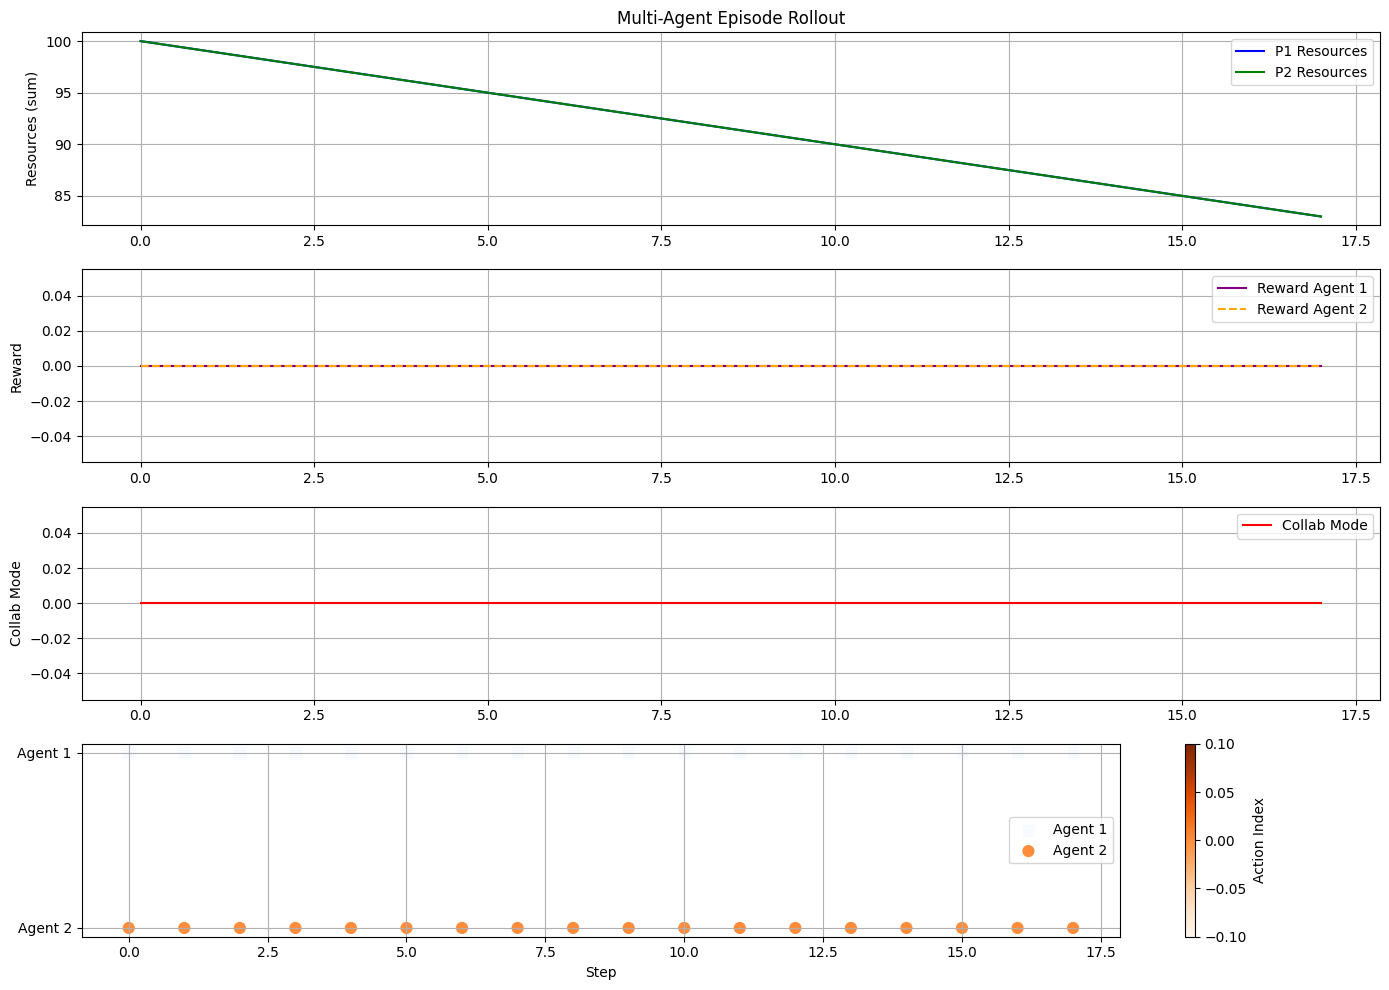

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def run_and_plot_episode_multiagent(agent1, agent2, env, preprocessor, device):
    obs, _ = env.reset()
    done = False
    steps = 0

    collab_trace = []
    p1_status_trace = []
    p2_status_trace = []
    p1_res_trace = []
    p2_res_trace = []
    action1_trace = []
    action2_trace = []
    reward1_trace = []
    reward2_trace = []

    while not done:
        # Preprocess observation
        processed_obs = preprocessor(obs)
        state = torch.tensor(processed_obs, dtype=torch.float32, device=device)
        if state.dim() == 1:
            state = state.unsqueeze(0)

        # Get actions from both agents
        action1 = agent1.policy_net(state).argmax(dim=1).item()
        action2 = agent2.policy_net(state).argmax(dim=1).item()

        # Record observation values
        collab_mode, p1_status, p2_status, p1_res, p2_res = obs
        collab_trace.append(collab_mode)
        p1_status_trace.append(p1_status)
        p2_status_trace.append(p2_status)
        p1_res_trace.append(np.sum(p1_res))  # e.g., sum of resource vector
        p2_res_trace.append(np.sum(p2_res))
        action1_trace.append(action1)
        action2_trace.append(action2)

        # Step environment
        obs, reward, done, _, _ = env.step((action1, action2))
        reward1_trace.append(reward[0])
        reward2_trace.append(reward[1])
        steps += 1

        if steps > 500:
            print("Episode cut off at 500 steps")
            break

    x = np.arange(len(action1_trace))

    plt.figure(figsize=(14, 10))

    plt.subplot(4, 1, 1)
    plt.plot(x, p1_res_trace, label="P1 Resources", color="blue")
    plt.plot(x, p2_res_trace, label="P2 Resources", color="green")
    plt.ylabel("Resources (sum)")
    plt.title("Multi-Agent Episode Rollout")
    plt.grid(True)
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(x, reward1_trace, label="Reward Agent 1", linestyle='-', color='purple')
    plt.plot(x, reward2_trace, label="Reward Agent 2", linestyle='--', color='orange')
    plt.ylabel("Reward")
    plt.grid(True)
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(x, collab_trace, label="Collab Mode", color='red')
    plt.ylabel("Collab Mode")
    plt.grid(True)
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.scatter(x, [1]*len(x), c=action1_trace, cmap="Blues", label="Agent 1", marker='s', s=60)
    plt.scatter(x, [0]*len(x), c=action2_trace, cmap="Oranges", label="Agent 2", marker='o', s=60)
    plt.xlabel("Step")
    plt.yticks([0, 1], ["Agent 2", "Agent 1"])
    plt.grid(True)
    plt.colorbar(label="Action Index")
    plt.legend()

    plt.tight_layout()
    plt.show()

run_and_plot_episode_multiagent(agent1, agent2, env, preprocessor, device)